In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import f_oneway

matplotlib.rcParams['svg.fonttype'] = 'none'

In [38]:
plasmadata = "/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/data/metabolomics/Plasma_summary.xlsx"

plasmapoolsize = pd.read_excel(plasmadata, sheet_name=3, header=0)
plasmanormalizedlabeling = pd.read_excel(plasmadata, sheet_name=2, header=0)
plasmaraw = pd.read_excel(plasmadata, sheet_name=0, header=0)

In [39]:
plasmaraw_glucose = plasmaraw[plasmaraw['Compound'] == 'Glucose']
raw2H_glucose = plasmaraw_glucose.groupby(['Compound','2H#']).sum().drop(columns=['13C#']).reset_index(level=[0,1])

In [40]:
#Average minute 110 and 120 for all mice

mice = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for x in mice:
    raw2H_glucose[str(x)+'_Avg'] = (raw2H_glucose[str(x)+'_110'] + raw2H_glucose[str(x)+'_120']) / 2

In [41]:
#Normalize to make fractions that add up to 1 for each column

raw2H_glucose_nml = raw2H_glucose.filter(regex='Avg') / raw2H_glucose.filter(regex='Avg').sum()

In [42]:
plasmaraw_glutamine = plasmaraw[plasmaraw['Compound'] == 'glutamine']
raw13C_glutamine = plasmaraw_glutamine.groupby(['Compound','13C#']).sum().drop(columns=['2H#']).reset_index(level=[0,1])

In [43]:
#Average minute 110 and 120 for all mice

mice = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for x in mice:
    raw13C_glutamine[str(x)+'_Avg'] = (raw13C_glutamine[str(x)+'_110'] + raw13C_glutamine[str(x)+'_120']) / 2

In [44]:
raw13C_glutamine_nml = raw13C_glutamine.filter(regex='Avg')  / raw13C_glutamine.filter(regex='Avg').sum()

In [45]:
#insert body weight (grams) from laboratory notebook Page 66

body_weight = [28.72, 27.8, 27.6, 28.1, 26.7, 29.5, 26.1, 25.1, 30.3, 28.5, 29.3, 27.3, 26.6, 28.9, 25.4]

infusion_rate_uL = [4.6, 4.4, 4.4, 4.5, 4.3, 4.7, 4.2, 4.0, 4.8, 4.6, 4.7, 4.4, 4.3, 4.6, 4.1]
#Infusion rate of glucose tracer in umol/kg/minute
#1 mg/kg/min is 5.34 umol/kg/min.
#5.34 * (weight/25) = infusion rate in uMol/kg/min

corrected_bw = [weight / 25 for weight in body_weight]

Infusion_Rate_umol = [bw * 5.34 for bw in corrected_bw]

#1 * (weight/25) = infusion rate in mg/kg/min
Infusion_Rate_mg = corrected_bw

Make background MDV with binomal expansion for d7-glucose

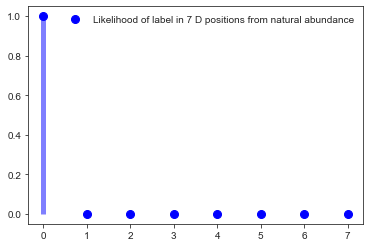

In [46]:
from scipy.stats import binom
#d7 glucose theoretical carbon distributions
#There are 7 labeled deuteriums with 0.0156% natural abundance
#So chance of label in each of the 7 positions is 0.000156

n, p = 7, 0.000156
x = np.arange(8)
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
fig, ax = plt.subplots(1, 1)
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='Likelihood of label in 7 D positions from natural abundance')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

rv = binom(n, p)

ax.legend(loc='best', frameon=False)

background2H_glucose_mdv = rv.pmf(x)

plt.show()

Make tracer MDV with binomal expansion for d7-glucose

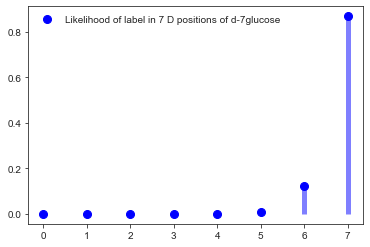

In [47]:
#d7 glucose theoretical carbon distributions
#There are 7 labeled deuteriums with 97-98% purity
#So chance of label in each of the 7 positions is 97.5

n, p = 7, 0.98
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
#Make a list from 0:7 and store it as an array
x = np.arange(8)
fig, ax = plt.subplots(1, 1)
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='Likelihood of label in 7 D positions of d-7glucose')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

rv = binom(n, p)

ax.legend(loc='best', frameon=False)

tracer_glucose_mdv = rv.pmf(x) 

plt.show()

In [48]:
# Add four 0s at end of tracer and background MDV to match length of plasma
tracer_glucose_mdv = np.append(tracer_glucose_mdv, [0,0,0,0,0])
background2H_glucose_mdv = np.append(background2H_glucose_mdv, [0,0,0,0,0])

Glucose Turnover as mg/kg/min.

In [49]:
#Calculate turnover for all samples using turnover function

import Kelleherturnover as turnover

Glucose_Turnover2H_mg = []

for col in raw2H_glucose_nml:
    x = turnover.Turnover_Ra(tracer_glucose_mdv, background2H_glucose_mdv,raw2H_glucose_nml[col].tolist(), 1)
    Glucose_Turnover2H_mg.append(x)

In [50]:
bw_corrected_glucose_turnover_mg = np.array(corrected_bw) * np.array(Glucose_Turnover2H_mg)

In [51]:
df = pd.DataFrame({"Glucose Turnover": bw_corrected_glucose_turnover_mg, "Condition": ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary']})

In [52]:
bw_corrected_glucose_turnover_mg

array([43.14855465, 42.16794152, 29.13265194, 41.96243134, 40.27326286,
       44.46613302, 27.83074994, 55.11806161, 47.97730571, 37.78320185,
       39.03297769, 38.77530004, 26.95363239, 35.93235405, 28.53522783])

<AxesSubplot:xlabel='Condition', ylabel='Glucose Turnover'>

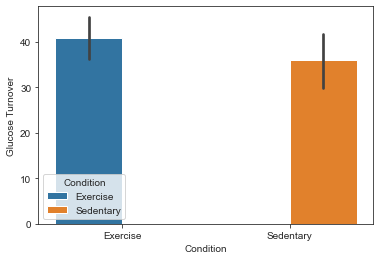

In [53]:
sns.barplot(data=df, x='Condition', y='Glucose Turnover', hue='Condition')

Glucose turnover as umol/kg/min.

In [54]:
#Calculate turnover for all samples using turnover function

Glucose_Turnover2H_mg = []

for col in raw2H_glucose_nml:
    x = turnover.Turnover_Ra(tracer_glucose_mdv, background2H_glucose_mdv,raw2H_glucose_nml[col].tolist(), 5.34)
    Glucose_Turnover2H_mg.append(x)

In [55]:
bw_corrected_glucose_turnover_umol = np.array(corrected_bw) * np.array(Glucose_Turnover2H_mg)
bw_corrected_glucose_turnover_umol

array([230.41328182, 225.17680769, 155.56836136, 224.07938337,
       215.05922367, 237.4491503 , 148.61620469, 294.33044899,
       256.19881251, 201.76229786, 208.43610087, 207.06010219,
       143.93239695, 191.87877061, 152.37811664])

In [56]:
df = pd.DataFrame({"Glucose Turnover": bw_corrected_glucose_turnover_umol, "Condition": ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary']})

In [57]:
glucose_turnover = df

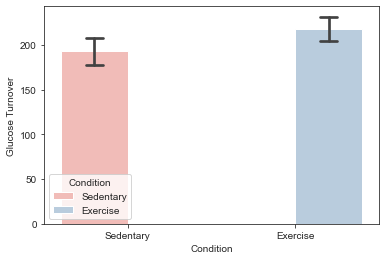

In [58]:
sns.set_style("white")
sns.set_style("ticks")

sns.barplot(data=df, x='Condition', y='Glucose Turnover', hue='Condition', palette = 'Pastel1', order=['Sedentary', 'Exercise'], hue_order=['Sedentary', 'Exercise'], ci=68, capsize=0.1)
plt.savefig('../figures/glucose_turnover.svg', bbox_inches="tight", dpi=300)

# Glutamine Turnover

Infusion rate of glutamine tracer in umol/kg/minute

7.5 umol/kg/min is 1.21 mg/kg/min.

7.5 * (weight/25) = infusion rate in uMol/kg/min

In [59]:
Gln_Infusion_Rate_umol = [bw * 7.5 for bw in corrected_bw]

#1 * (weight/25) = infusion rate in mg/kg/min
Gln_Infusion_Rate_mg = [bw * 1.21 for bw in corrected_bw]

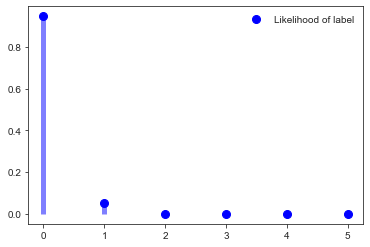

In [60]:
#U13C Glutamine theoretical carbon distributions
#There are 5 labeled carbons with 1.11% natural abundance
#So chance of label in each of the 5 positions is 0.011

n, p = 5, 0.011
x = np.arange(6)
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
fig, ax = plt.subplots(1, 1)
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='Likelihood of label')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

rv = binom(n, p)

ax.legend(loc='best', frameon=False)

background_glutamine_mdv = rv.pmf(x)

plt.show()

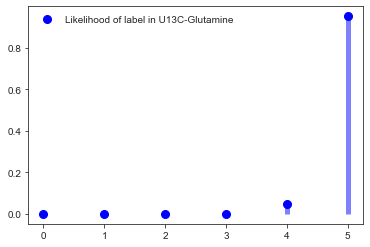

In [61]:
#There are 5 labeled carbons with 99% purity
#So chance of label in each of the 5 positions is 0.99

n, p = 5, 0.99
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
#Make a list from 0:7 and store it as an array
x = np.arange(6)
fig, ax = plt.subplots(1, 1)
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='Likelihood of label in U13C-Glutamine')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

rv = binom(n, p)

ax.legend(loc='best', frameon=False)

tracer_glutamine_mdv = rv.pmf(x) 

plt.show()

Glutamine Turnover as mg/kg/min.

In [62]:
#Calculate turnover for all samples using turnover function

Glutamine_Turnover_mg = []

for col in raw2H_glucose_nml:
    x = turnover.Turnover_Ra(tracer_glutamine_mdv, background_glutamine_mdv,raw13C_glutamine_nml[col].tolist(), 1.21)
    Glutamine_Turnover_mg.append(x)

In [63]:
bw_corrected_glutamine_turnover_mg = np.array(corrected_bw) * np.array(Glutamine_Turnover_mg)
bw_corrected_glutamine_turnover_mg

array([13.12644968, 16.61463976,  9.70640191, 15.92868773, 14.58153534,
       19.35288233, 11.04334197, 17.32511642, 18.50538038, 16.43579566,
       12.69846637, 14.668719  , 10.79149431, 13.56178647, 14.55457072])

In [64]:
df = pd.DataFrame({"Glutamine Turnover": bw_corrected_glutamine_turnover_mg, "Condition": ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary']})

<AxesSubplot:xlabel='Condition', ylabel='Glutamine Turnover'>

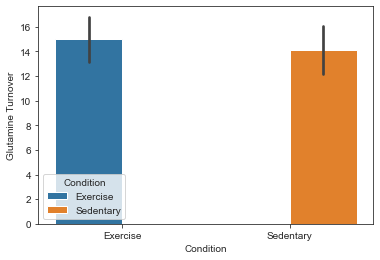

In [65]:
sns.barplot(data=df, x='Condition', y='Glutamine Turnover', hue='Condition')

In [66]:
#Calculate turnover for all samples using turnover function

Glutamine_Turnover_umol = []

for col in raw2H_glucose_nml:
    x = turnover.Turnover_Ra(tracer_glutamine_mdv, background_glutamine_mdv,raw13C_glutamine_nml[col].tolist(), 7.5)
    Glutamine_Turnover_umol.append(x)

In [67]:
bw_corrected_glutamine_turnover_umol = np.array(corrected_bw) * np.array(Glutamine_Turnover_umol)

In [68]:
df = pd.DataFrame({"Glutamine Turnover": bw_corrected_glutamine_turnover_umol, "Condition": ['Exercise', 'Sedentary', 'Exercise', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary', 'Exercise', 'Sedentary']})

In [69]:
glutamine_turnover = df

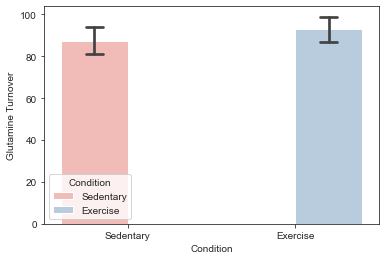

In [70]:
sns.set_style("white")
sns.set_style("ticks")

sns.barplot(data=df, x='Condition', y='Glutamine Turnover', hue='Condition', palette = 'Pastel1', order=['Sedentary', 'Exercise'], hue_order=['Sedentary', 'Exercise'], ci=68, capsize=0.1)
plt.savefig('../figures/glutamine_turnover.svg', bbox_inches="tight", dpi=300)

In [71]:
glutamine_turnover

,Glutamine Turnover,Condition
0,81.362291,Exercise
1,102.983304,Sedentary
2,60.163648,Exercise
3,98.731536,Exercise
4,90.381417,Sedentary
5,119.955882,Exercise
6,68.450467,Sedentary
7,107.387085,Exercise
8,114.702771,Sedentary
9,101.874766,Exercise


In [72]:
glucose_turnover['Glutamine Turnover'] = glutamine_turnover['Glutamine Turnover'].tolist()

In [47]:
glucose_turnover.to_csv('/Users/brooksleitner/Desktop/Python/PerryLabData/ExerciseCancer/ExerciseCancerMouseData/data/metabolomics/turnover.csv')